In [1]:
from PIL import Image
import glob
import numpy as np
from numpy import linalg as la
from pylab import *
import matplotlib.pyplot as plt 

image=[]
flattened_images  =[]
def griddisplay(image_list):
    rows = int(len(image_list) / 5) 
    fig1, axes_array = plt.subplots(rows, 5)
    fig1.set_size_inches(5,5)
    k=0
    for row in range(rows):
        for col in range(5):    
            im = np.array(Image.fromarray(image_list[k]).resize((100, 100), Image.ANTIALIAS))
            axes_array[row][col].imshow(im,cmap=plt.cm.gray) 
            axes_array[row][col].axis('off')
            k = k+1
    plt.show()

for i in range(0,105):
    filename = r'C:\Users\power\Desktop\cv-task5\AllData\TrainingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    image.append(im)

TrainImages_num = len(image)


for i in range(TrainImages_num):
    p=image[i].flatten()
    flattened_images.append(p)
A_transpose = np.matrix(flattened_images)
A = np.transpose(A_transpose)

mean= np.mean(A,1)
b= mean.reshape(128,128)
resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))

zero_mean =[]
column =0
Zero_mean_matrix= np.ones((16384,TrainImages_num))
for values in flattened_images:
    zm= A[:,column] - mean         # zm = values - mean
    zm = np.squeeze(zm)
    Zero_mean_matrix[:,column] =zm
    zm_images = zm.reshape(128,128)
    zero_mean.append(zm)
    column = column +1

d = (np.dot(np.transpose(Zero_mean_matrix),Zero_mean_matrix))/425
u_list =[]
w2, v2 = la.eigh(d)

for ev in v2:
    ev_transpose = np.transpose(np.matrix(ev))
    u = np.dot(Zero_mean_matrix,ev_transpose)                        
    u = u / np.linalg.norm(u)
    u_i= u.reshape(128,128)
    u_list.append(u_i)

C:\Users\power\AppData\Local\Temp\ipykernel_25904\3363976498.py:40: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resized_mean=np.array(Image.fromarray(np.asarray(b)).resize((100, 100), Image.BILINEAR))


In [2]:
dict ={}
def Reconstruct(k):
    weights=np.zeros((TrainImages_num,k))
    matrixU = np.zeros((16384,k))
    c =0
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    rec_face=[]
    for face_num in range(0,TrainImages_num):
        w = np.dot(np.transpose(matrixU) ,Zero_mean_matrix[:,face_num])
        weights[face_num,:] =w

        face = np.dot(w, np.transpose(matrixU))
        minf = np.min(face)
        maxf = np.max(face)
        face = face-float(minf)
        face = face/float((maxf-minf))
        face = face+np.transpose(mean)
        reshape_face = face.reshape(128,128)
        rec_face.append( reshape_face)
    dict[k] = weights

Reconstruct(103)


		k=103
13.476317021959114
11


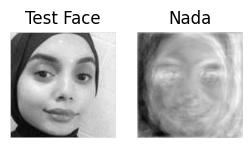

29.833243741026337
102


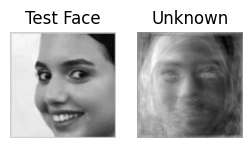

13.328155644100804
12


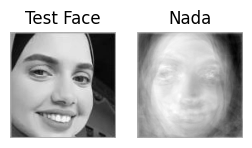

25.639144999168906
13


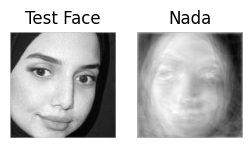

22.965496078275702
77


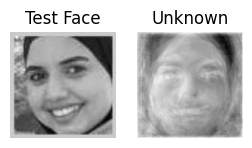

31.071213190897573
7


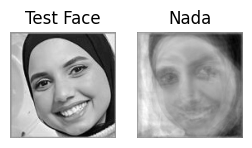

23.154940728255415
80


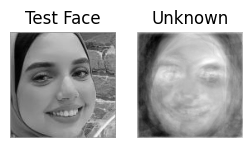

17.101151458770566
55


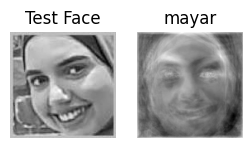

22.009863364988576
10


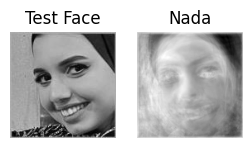

33.61287429825676
9


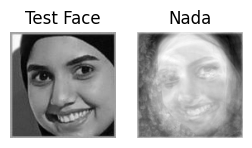

6.171244841216034
29


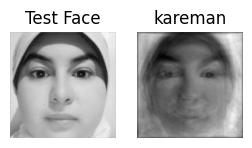

51.52199240213662
39


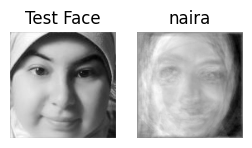

0.0
16


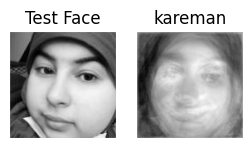

35.9597227032789
76


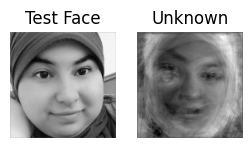

7.287314066805169
26


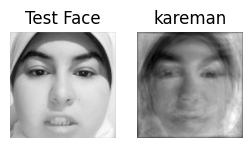

44.38586065438301
100


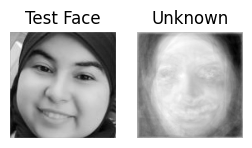

27.119156303813632
20


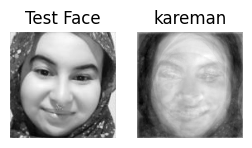

37.671200423763146
16


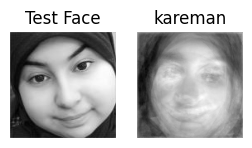

9.737298833260652
24


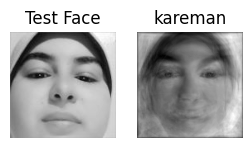

0.0
27


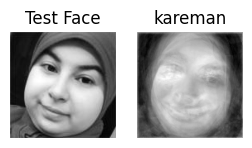

24.65501388714744
42


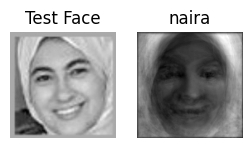

15.713899419110447
84


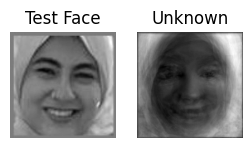

35.047986342460234
40


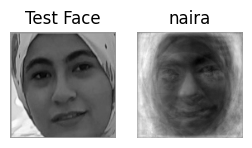

17.303872398865764
33


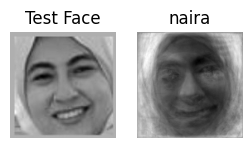

22.860875711224885
41


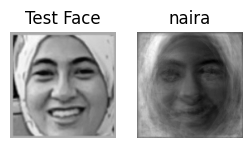

15.47726567219823
30


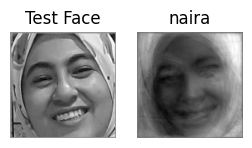

28.669762607649538
84


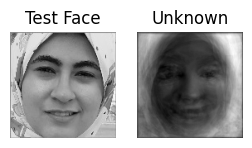

20.720135650131454
40


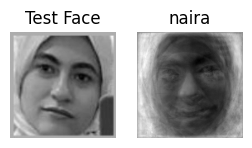

33.43642954316893
31


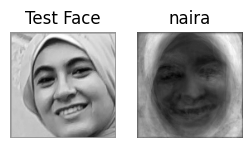

25.982360392849213
74


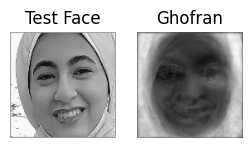

0.0
45


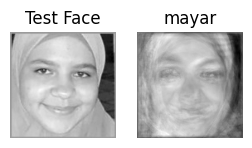

24.75922833652266
42


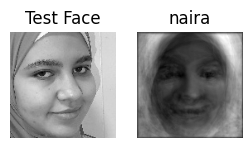

34.41091054767636
81


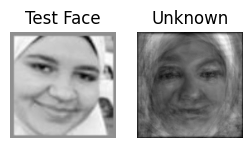

0.0
51


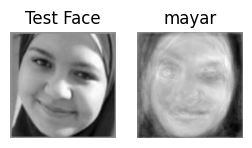

0.0
50


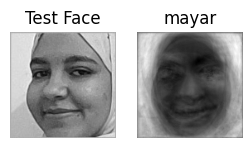

23.837961301467864
99


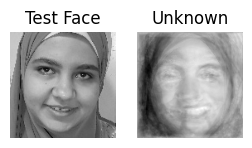

0.0
56


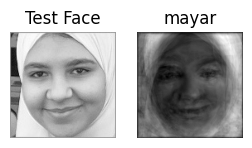

0.0
57


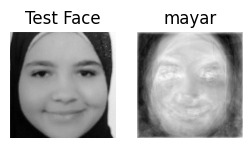

24.23631364253513
47


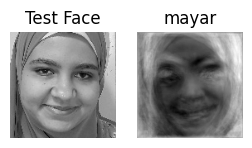

0.0
59


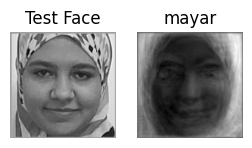

0.0
60


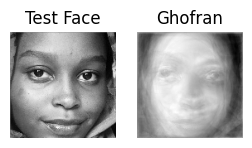

0.0
61


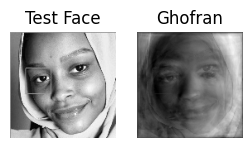

0.0
62


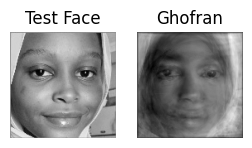

0.0
63


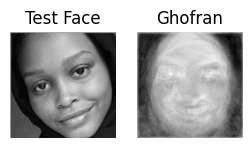

0.0
69


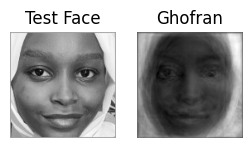

0.0
66


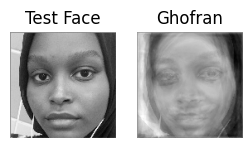

0.0
65


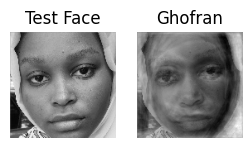

0.0
64


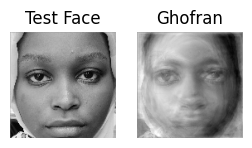

0.0
68


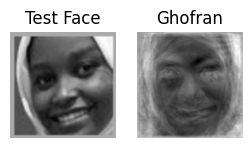

0.0
67


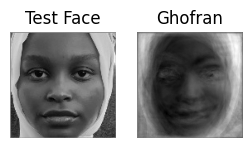

0.0
84


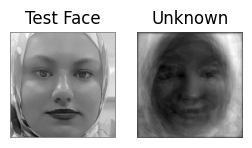

0.0
76


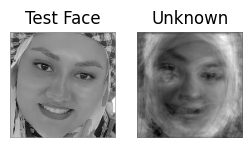

0.0
77


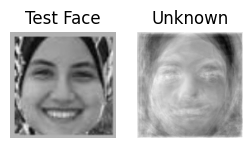

0.0
79


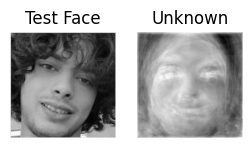

0.0
78


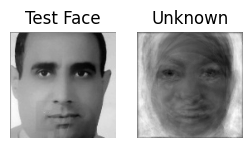

0.0
81


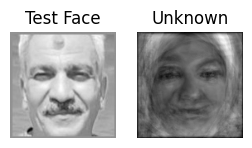

0.0
82


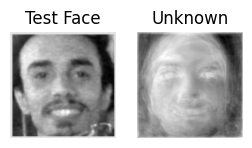

0.0
80


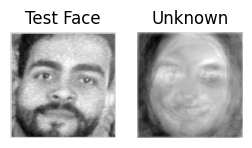

0.0
101


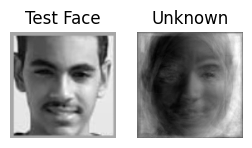

0.0
75


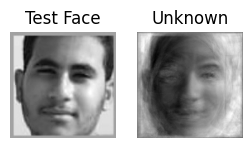

0.0
83


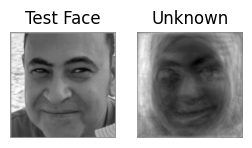

In [7]:
test_images=[]

# for filename in glob.glob(r'C:\Users\power\Desktop\cv-task5\AllData\TestingImages\*.jpg'):
    # im=Image.open(filename).convert('L')
    # im= np.asarray(im,dtype=float)/255.0 
    # test_images.append(im)

for i in range(0,61):
    filename =r'C:\Users\power\Desktop\cv-task5\AllData\TestingImages\Face' +str(i) + '.jpg'
    im=Image.open(filename).convert('L')
    im= np.asarray(im,dtype=float)/255.0 
    test_images.append(im)

def Project(k, zero_mean_test, threshold):
    matrixU = np.zeros((16384, k))
    c = 0
    name=""
    for val in range(k-1, -1, -1):
        matrixU[:, c] = u_list[val].flatten()
        c = c + 1
    w = np.dot(np.transpose(matrixU), np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist = []
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))
    print (np.min(dist))
    nearest_face = np.argmin(dist)
    print (nearest_face)
    nearest_face_weights = original_w_k[nearest_face]
    zero_mean_test = zero_mean_test + np.transpose(mean)
    face = np.dot(nearest_face_weights, np.transpose(matrixU))
    face = face + np.transpose(mean)
    reshape_face = face.reshape(128, 128)
    if np.min(dist) < threshold:  
        index = nearest_face
        if index in range(0,15):
            name="Nada"
        elif index in range(15,30):
            name="kareman"
        elif index in range(30,45):
            name="naira"
        elif index in range(45,60):
            name="mayar"
        elif index in range(60,75):
            name="Ghofran"    
        elif index in range(75,105):
            name="Unknown"    
    else:
        index = -1
        name = 'Unknown'
    return index, name, reshape_face
    
def runs(k):
    for num in range(len(test_images)):
        t = test_images[num]
        test = t.flatten()
        zero_mean_test = test - np.transpose(mean)
        index, name, face = Project(k, zero_mean_test, 80)  # threshold = 80
        fig1, axes_array = plt.subplots(1, 2)
        fig1.set_size_inches(3, 3)
        image_plot = axes_array[0].imshow(t, cmap=plt.cm.gray)
        axes_array[0].axis('off')
        axes_array[0].set(title='Test Face')
        image_plot = axes_array[1].imshow(face, cmap=plt.cm.gray)
        axes_array[1].axis('off')
        axes_array[1].set(title = name)
        plt.show()

print('\t\tk=103')
runs(103)

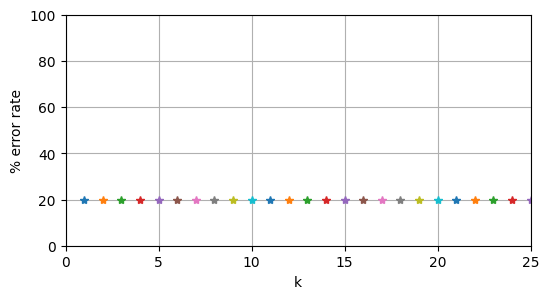

In [18]:
def Error(k,threshold):
    Nonfaces = 10
    total_images = 50
    nf_detected = 0
    matrixU = np.zeros((16384,k))
    c = 0
    
    for val in range(k-1,-1,-1):
        matrixU[:,c] = u_list[val].flatten()
        c = c+1
    
    for t in test_images:
        test = t.flatten()
        zero_mean_test = test-np.transpose(mean)
        w = np.dot(np.transpose(matrixU) ,np.transpose(zero_mean_test))
        original_w_k =dict[k]
        dist =[]
        for wt_vectors in original_w_k:
            dist.append(np.linalg.norm(wt_vectors-w.T))
        
        if np.min(dist) > threshold:
            nf_detected = nf_detected + 1

    
    error_percentage = ((Nonfaces - nf_detected)/total_images) *100
    return error_percentage

xt =[]
for x in range(1,40):
    Reconstruct(x)
    xt.append(x)


fig, axes1 = plt.subplots(1, 1)
fig.set_size_inches(6,3)
for x_pts in xt:
    y= Error(x_pts,80)
    axes1.plot(x_pts, y,marker='*')
axes1.set(xlabel="k",ylabel="% error rate",ylim=(0,100),xlim=(0,25))
plt.grid(True)
plt.show()


In [8]:

def Project(k, zero_mean_test):
    matrixU = np.zeros((16384, k))
    c = 0
    for val in range(k-1, -1, -1):
        matrixU[:, c] = u_list[val].flatten()
        c = c + 1
    w = np.dot(np.transpose(matrixU), np.transpose(zero_mean_test))
    original_w_k = dict[k]
    dist = []
    for wt_vectors in original_w_k:
        dist.append(np.linalg.norm(wt_vectors-w.T))
    nearest_face = np.argmin(dist)
    nearest_distance = dist[nearest_face]
    return nearest_face, nearest_distance
from sklearn.metrics import roc_curve, auc
# from sklearn.metrics import roc_curve 
def create_roc_curve():
    distances = []
    labels = []
    # fpr = dict()
    # tpr = dict()
    # roc_auc = dict()
    # for i in range(0,4):
        # fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        # roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(len(test_images)):
        test_image = test_images[i]
        zero_mean_test = test_image.flatten() - mean
        nearest_face, nearest_distance = Project(103, zero_mean_test)
        distances.append(nearest_distance)
        if i < 15:
            labels.append(0)  # Nada
        elif i < 30:
            labels.append(1)  # Kareman
        elif i < 45:
            labels.append(2)  # Naira
        elif i < 60:
            labels.append(3)  # Mayar
        elif i < 75:
            labels.append(4)  # Ghofran
        else:
            labels.append(5)  # Unknown
    fpr, tpr, thresholds = roc_curve(labels, distances, pos_label='your_label')
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

create_roc_curve()


TypeError: 'dict' object is not callable